In [32]:
!pip install optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import shap
import plotly.express as px
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

In [33]:
# Load Data
df = pd.read_csv("/content/gold_monthly_csv.csv", parse_dates=["Date"], index_col="Date")

In [34]:
# Feature Engineering
df["DayOfWeek"] = df.index.dayofweek
df["Quarter"] = df.index.quarter
df["IsWeekend"] = (df["DayOfWeek"] >= 5).astype(int)
df["Month_sin"] = np.sin(2 * np.pi * df.index.month / 12)
df["Month_cos"] = np.cos(2 * np.pi * df.index.month / 12)
df["Lag_1"] = df["Price"].shift(1)
df["Lag_7"] = df["Price"].shift(7)
df["Lag_30"] = df["Price"].shift(30)
df["EWMA_7"] = df["Price"].ewm(span=7).mean()
df.dropna(inplace=True)

In [35]:
# Data Preprocessing & Scaling
scaler_lstm = MinMaxScaler()
scaler_tree = StandardScaler()
df_scaled_lstm = scaler_lstm.fit_transform(df)
df_scaled_tree = scaler_tree.fit_transform(df)

In [46]:
# Splitting Data
scaler_lstm = MinMaxScaler()
scaler_tree = StandardScaler()
train_size = int(len(df) * 0.8)

train = df.iloc[:train_size]
test = df.iloc[train_size:]

train_scaled_lstm = scaler_lstm.fit_transform(train)
test_scaled_lstm = scaler_lstm.transform(test)

train_scaled_tree = scaler_tree.fit_transform(train)
test_scaled_tree = scaler_tree.transform(test)

In [37]:
# Hyperparameter Optimization for XGBoost
def objective_xgb(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 200),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return mean_absolute_error(y_test, preds)

study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(objective_xgb, n_trials=20)
best_params_xgb = study_xgb.best_params
xgb_model = xgb.XGBRegressor(**best_params_xgb)
xgb_model.fit(X_train, y_train)

[I 2025-03-05 03:16:24,530] A new study created in memory with name: no-name-d2bab938-7a2d-4378-8290-7643aacede65
<ipython-input-37-bc7319362eef>:5: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

<ipython-input-37-bc7319362eef>:7: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

<ipython-input-37-bc7319362eef>:8: FutureWarning:

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.

[I 2025-03-05 03:16:24,594] Trial 0 finished with value: 0.3996407211325606 and parameters: {'n_estimators': 115, 'learning_rate': 0.018234590805537264, 'max_depth': 6, 'subsample': 0.994912479909

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6127050621858093, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05105987386440733, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=169, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [38]:
# LSTM Model
sequence_length = 10  # Can be optimized further
generator = TimeseriesGenerator(X_train, y_train, length=sequence_length, batch_size=16)
lstm_model = Sequential([
    Bidirectional(LSTM(100, return_sequences=True, input_shape=(sequence_length, X_train.shape[1]))),
    Dropout(0.2),
    GRU(100, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(generator, epochs=20, verbose=1)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0209
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0015
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.6209e-04
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.9503e-04
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8.1088e-04
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0013
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 7.3141e-04
Epoch 9/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0021
Epoch 10/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.8283e-04
Epoch 11/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0011
Epoch 12/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 7.8870e-04
Epoch 13/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.1938e-04
Epoch 14/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 6.9899e-04
Epoch 15/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/ste

In [51]:
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_test: (164, 9)
Shape of y_test: (154,)


In [52]:
min_len = min(len(X_test), len(y_test))
X_test, y_test = X_test[:min_len], y_test[:min_len]

In [53]:
# XGBoost Predictions
xgb_pred = xgb_model.predict(X_test)

# LSTM Predictions - Ensure Correct Reshaping
# The original line caused the error due to incompatible shapes.
# Instead, we need to create sequences for the LSTM using TimeseriesGenerator.
test_gen = TimeseriesGenerator(X_test, y_test, length=10, batch_size=16, start_index=10)
lstm_pred = lstm_model.predict(test_gen).flatten()

# Trim XGBoost and y_test to match LSTM output size
xgb_pred = xgb_pred[-len(lstm_pred):]
y_test_trimmed = y_test[-len(lstm_pred):]

# Ensemble Strategy with Ridge Regression
min_len = min(len(xgb_pred), len(lstm_pred))
ensemble_X = np.column_stack((xgb_pred[:min_len], lstm_pred[:min_len]))
y_test = y_test[:min_len]
ridge = Ridge()
ridge.fit(ensemble_X, y_test_trimmed)
ensemble_pred = ridge.predict(ensemble_X)

# Evaluation Function
from sklearn.metrics import r2_score, mean_absolute_percentage_error

def evaluate(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"{model_name}: MAE={mae:.4f}, RMSE={rmse:.4f}, R²={r2:.4f}, MAPE={mape:.4%}")

# Evaluate All Models
evaluate(y_test_trimmed, xgb_pred, "XGBoost")
evaluate(y_test_trimmed, lstm_pred, "LSTM")
evaluate(y_test_trimmed, ensemble_pred, "Ensemble")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
XGBoost: MAE=0.3826, RMSE=0.4021, R²=-9.8955, MAPE=53.4869%
LSTM: MAE=0.0421, RMSE=0.0520, R²=0.8181, MAPE=6.1282%
Ensemble: MAE=0.0507, RMSE=0.0652, R²=0.7136, MAPE=7.6145%


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



In [54]:
print(f"New X_test shape: {X_test.shape}, New y_test shape: {y_test.shape}")

New X_test shape: (154, 9), New y_test shape: (134,)


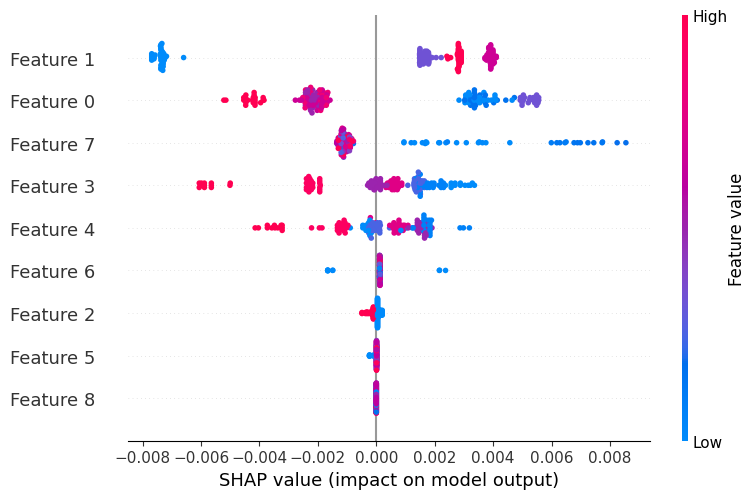

In [55]:
# SHAP Feature Importance
explainer = shap.Explainer(xgb_model, X_test)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

# Visualization
fig = px.line(df, x=df.index, y="Price", title="Time Series Data")
fig.add_trace(go.Scatter(x=df.index[train_size:], y=ensemble_pred, mode='lines', name='Predicted'))
fig.show()

# Save Models
import datetime
version = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
joblib.dump(xgb_model, f"xgb_model_{version}.pkl")
lstm_model.save(f"lstm_model_{version}.h5")